# Fourier Features Deep Dive (All Datasets)

This notebook performs a focused *deep dive* analysis on **Fourier features** for
the binary classification problem.  The goal is to test each of :

- **HGLG vs MGLG**: Human-generated, Llama-graded vs Mixtral-generated, Llama-graded (Reuters-50/50 subset)
- **HGMG vs LGMG**: Human-generated, Mixtral-graded vs LLaMA-generated, Mixtral-graded (Reuters-50/50 subset)
- **HGMG vs LGMG**: Human-generated, Mixtral-graded vs LLaMA-generated, Mixtral-graded (Reuters-50/50 subset)
- **MAGE-LG**: Mixtral-graded MAGE dataset, scored by Llama
- **MAGE-MG**: Mixtral-graded MAGE dataset, scored by Mixtral
- **MAGE-LG**: Mixtral-graded MAGE dataset, scored by Llama
- **MAGE-MG**: Mixtral-graded MAGE dataset, scored by Mixtral

We concentrate on features:

- **fft_high_energy_ratio_cut{c}** (c ∈ {0.5, 0.75, 0.9})  
  Fraction of total power in frequencies ≥ c·f_Nyquist.  
  *How:* compute real FFT; power spectrum P = |FFT(x)|^2, then sum power above index floor(c·len(P)) divided by total power.  
  *Why:* higher ratios indicate more high-frequency fluctuation, a possible marker of local unpredictability.

- **spectral_centroid**  
  Power-weighted average frequency index: sum(k*P_k) / sum(P_k).  
  *Why:* measures where energy “lives” in the spectrum (low vs high frequencies).

- **spectral_slope**  
  Slope of a linear fit of log(P_k + epsilon) versus frequency index k.  
  *Why:* negative slopes indicate spectra dominated by low frequencies (smoother signals); flatter/positive slopes suggest relatively more high-frequency content.

- **spectral_flatness**  
  Measures how “peaky” or “noise-like” the spectrum is.  
  *How:* compares the geometric mean of the power spectrum to its arithmetic mean.  
  *Why:* values near 1 indicate a flat, noise-like spectrum; values near 0 indicate strong peaks.

- **spectral_entropy**  
  Measures how evenly the spectral energy is spread across all frequencies.  
  *How:* treat the normalized power spectrum like a probability distribution and compute its Shannon entropy.  
  *Why:* high entropy means the energy is broadly distributed; low entropy means it’s concentrated in a small number of bands.

**Additionally**, we use windowing for these features to see if there are local patterns

In [83]:
import os, glob
import numpy as np
import pandas as pd
from typing import Iterable

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from fingerprinting_llms.score import LogProbs

#   Llama-graded
HUMAN_REUTERS_LLAMA    = 'data/tokens/human_llama-graded/reuter5050/C50train_clean'
LLM_REUTERS_LLAMA_LLAMA      = 'data/tokens/llama70Bw4a16/reuter5050/C50train_clean'
LLM_REUTERS_MIXTRAL_LLAMA      = 'data/tokens/bigmixtral-llama70Bw4a16-graded/reuter5050/C50train_clean'
HUMAN_HC3_LLAMA    = 'data/tokens/hc3/human_llama-graded'
LLM_HC3_LLAMA      = 'data/tokens/hc3/chatgpt_llama-graded'
HUMAN_MAGE_LLAMA    = 'data/tokens/mage/human_llama-graded'
LLM_MAGE_LLAMA      = 'data/tokens/mage/llm_llama-graded'

#   Mixtral-graded
HUMAN_REUTERS_MIXTRAL  = 'data/tokens/human_bigmixtral-graded/reuter5050/C50train_clean'
LLM_REUTERS_LLAMA_MIXTRAL    = 'data/tokens/llama70Bw4a16-bigmixtral-graded/reuter5050/C50train_clean'
HUMAN_HC3_MIXTRAL    = 'data/tokens/hc3/human_mixtral-graded'
LLM_HC3_MIXTRAL      = 'data/tokens/hc3/chatgpt_mixtral-graded'
HUMAN_MAGE_MIXTRAL    = 'data/tokens/mage/human_mixtral-graded'
LLM_MAGE_MIXTRAL      = 'data/tokens/mage/llm_mixtral-graded'

RNG = np.random.default_rng(42)


## Data Loading Helpers

In [84]:
def find_all_npz(root_dir: str) -> list[str]:
    return sorted(glob.glob(os.path.join(root_dir, '**', '*.npz'), recursive=True))

def load_logp_series_from_root(root_dir: str) -> list[np.ndarray]:
    paths = find_all_npz(root_dir)
    series = []
    for p in paths:
        if LogProbs is not None:
            lp = LogProbs.from_file(p)
            probs = np.asarray(lp.token_probs, dtype=np.float64)
        else:
            with np.load(p, allow_pickle=True) as npzfile:
                if 'token_probs' not in npzfile:
                    continue
                probs = np.asarray(npzfile['token_probs'], dtype=np.float64)

        series.append(probs)
    return series


## Fourier Features

In [85]:
def spectral_flatness(P: np.ndarray) -> float:
    """
    Spectral flatness (Wiener entropy).

    Returns a value in [0, 1] where:
      ~1 => flat / noise-like spectrum
      ~0 => very peaky spectrum

    We use the ratio of geometric mean to arithmetic mean of the power spectrum.
    """
    P = np.asarray(P, dtype=np.float64)
    if P.size == 0:
        return 0.0

    # Remove non-positive entries to avoid log issues; if all <=0, return 0
    P_pos = P[P > 0]
    if P_pos.size == 0:
        return 0.0

    # Geometric mean
    log_P = np.log(P_pos)
    geo_mean = np.exp(log_P.mean())

    # Arithmetic mean (use positive part for consistency)
    arith_mean = P_pos.mean()
    if arith_mean <= 0:
        return 0.0

    flatness = geo_mean / arith_mean
    # clamp to [0, 1] for numerical safety
    flatness = float(np.clip(flatness, 0.0, 1.0))
    return flatness


def spectral_entropy(P: np.ndarray, normalize: bool = True) -> float:
    """
    Spectral (Shannon) entropy of the normalized power spectrum.

    If normalize=True (default), returns a value in [0, 1]:
      0   => all energy in one bin
      1   => energy perfectly spread (uniform over bins)
    """
    P = np.asarray(P, dtype=np.float64)
    if P.size == 0:
        return 0.0

    total = P.sum()
    if total <= 0:
        return 0.0

    p = P / total
    # Avoid log(0) by masking or adding epsilon
    p = np.clip(p, 1e-12, 1.0)
    H = -np.sum(p * np.log(p))  # natural log

    if normalize:
        # Max entropy is log(K) for uniform distribution over K bins
        H_max = np.log(P.size)
        if H_max > 0:
            H = H / H_max
        else:
            H = 0.0

    return float(H)


def fft_power_spectrum(x: np.ndarray) -> np.ndarray:
    """Compute zero-mean real FFT power spectrum of a 1D sequence."""
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0:
        return np.array([], dtype=np.float64)
    x = x - x.mean()
    X = np.fft.rfft(x)
    P = np.abs(X)**2
    return P

def fourier_energy_ratio(P: np.ndarray, frac_cut: float) -> float:
    """Fraction of total power in frequencies >= frac_cut * Nyquist index."""
    if P.size == 0:
        return 0.0
    total = P.sum()
    if total <= 0:
        return 0.0
    cut = int(np.floor(frac_cut * P.size))
    cut = min(max(cut, 0), P.size)  # clamp to [0, P.size]
    high = P[cut:].sum()
    return float(high / total)

def spectral_centroid(P: np.ndarray) -> float:
    """Power-weighted average frequency index."""
    if P.size == 0:
        return 0.0
    w = np.arange(P.size, dtype=np.float64)
    denom = P.sum()
    if denom <= 0:
        return 0.0
    return float((w * P).sum() / denom)

def spectral_slope(P: np.ndarray) -> float:
    """Slope of log power vs. frequency index."""
    if P.size < 2:
        return 0.0
    w = np.arange(P.size, dtype=np.float64)
    y = np.log(P + 1e-12)
    w_mean = w.mean()
    y_mean = y.mean()
    num = np.sum((w - w_mean) * (y - y_mean))
    den = np.sum((w - w_mean)**2)
    if den <= 0:
        return 0.0
    return float(num / den)


def windowed_fourier_features(
    x: np.ndarray,
    window_sizes: tuple[int] = (64,128),
    hop_size: int | None = None,
    frac_cuts: Iterable[float] = (0.5, 0.75, 0.9),
) -> dict[str, float]:
    """
    Compute windowed Fourier features over a 1D sequence.
    """
    x = np.asarray(x, dtype=np.float64)

    features: dict[str, float] = {}
    for window_size in window_sizes:

        if hop_size is None:
            hop_size = window_size // 2
            if hop_size <= 0:
                hop_size = 1

        N = x.size
        window_starts = list(range(0, max(N - window_size + 1, 0), hop_size))

        # If the series is shorter than window_size, use a single window over the whole series
        if len(window_starts) == 0 and N > 0:
            window_starts = [0]
            window_size_eff = N
        else:
            window_size_eff = window_size

        # Collect per-window feature values
        energy_ratios: dict[float, list[float]] = {c: [] for c in frac_cuts}
        centroids: list[float] = []
        slopes: list[float] = []
        entropies: list[float] = []
        flatnesses: list[float] = []

        for start in window_starts:
            end = start + window_size_eff
            segment = x[start:end]
            if segment.size < 2:
                continue  # skip tiny segments

            P = fft_power_spectrum(segment)

            # Energy ratios for each cutoff
            for c in frac_cuts:
                energy_ratios[c].append(fourier_energy_ratio(P, c))

            # Centroid and slope
            centroids.append(spectral_centroid(P))
            slopes.append(spectral_slope(P))
            entropies.append(spectral_entropy(P))
            flatnesses.append(spectral_flatness(P))

        num_windows = len(centroids)  # all lists should have same length if not skipped

        features["num_windows"] = float(num_windows)

        if num_windows == 0:
            # No valid windows -> all zeros
            for c in frac_cuts:
                c_str = f"{c:.2f}"
                features[f"fft_energy_ratio_cut{c_str}_w{window_size}_mean"] = 0.0
                features[f"fft_energy_ratio_cut{c_str}_std"] = 0.0
            features[f"spectral_centroid_w{window_size}_mean"] = 0.0
            features[f"spectral_centroid_w{window_size}_std"] = 0.0
            features[f"spectral_slope_w{window_size}_mean"] = 0.0
            features[f"spectral_slope_w{window_size}_std"] = 0.0
            features[f"spectral_entropy_w{window_size}_std"] = 0.0
            features[f"spectral_flatness_w{window_size}_std"] = 0.0
            return features

        # Aggregate statistics across windows
        for c in frac_cuts:
            vals = np.asarray(energy_ratios[c], dtype=np.float64)
            c_str = f"{c:.2f}"
            features[f"fft_energy_ratio_cut{c_str}_w{window_size}_mean"] = float(vals.mean())
            features[f"fft_energy_ratio_cut{c_str}_w{window_size}_std"] = float(vals.std(ddof=0))

        centroids_arr = np.asarray(centroids, dtype=np.float64)
        slopes_arr = np.asarray(slopes, dtype=np.float64)
        entropy_arr = np.asarray(entropies, dtype=np.float64)
        flatness_arr = np.asarray(flatnesses, dtype=np.float64)


        features[f"spectral_centroid_w{window_size}_mean"] = float(centroids_arr.mean())
        features[f"spectral_centroid_w{window_size}_std"] = float(centroids_arr.std(ddof=0))
        features[f"spectral_slope_w{window_size}_mean"] = float(slopes_arr.mean())
        features[f"spectral_slope_w{window_size}_std"] = float(slopes_arr.std(ddof=0))
        features[f"spectral_entropy_w{window_size}_mean"] = float(entropy_arr.mean())
        features[f"spectral_entropy_w{window_size}_std"] = float(entropy_arr.std(ddof=0))
        features[f"spectral_flatness_w{window_size}_mean"] = float(flatness_arr.mean())
        features[f"spectral_flatness_w{window_size}_std"] = float(flatness_arr.std(ddof=0))

    return features


# Feature Extractor 

For this deep dive, we focus on the features that do not include Stats or Wavelet transforms.

In [86]:
def extract_features_from_logp(x: np.ndarray) -> dict[str, float]:
    """Extract features from a 1D log-probability array."""
    x = np.asarray(x, dtype=np.float64)
    feats: dict[str, float] = windowed_fourier_features(x=x, window_sizes=(64, 128), frac_cuts=(0.5, 0.75, 0.9))
    return feats

# <a color="red"><u>REUTERS</u></a>

## Llama-Generated, Mixtral-Graded

## Build Fourier-Only Feature DataFrame (HGMG vs LGMG)

We now build a dataframe of features for:

- Human-generated, Mixtral-graded (HGMG) Reuters documents
- LLaMA-generated, Mixtral-graded (LGMG) Reuters documents 


In [87]:
def build_feature_df(human_root: str, llm_root: str) -> pd.DataFrame:
    human_series = load_logp_series_from_root(human_root)
    llm_series   = load_logp_series_from_root(llm_root)

    rows = []
    for idx, seq in enumerate(human_series):
        feats = extract_features_from_logp(seq)
        feats['label'] = 'human'
        feats['doc_id'] = f'human_{idx}'
        rows.append(feats)

    for idx, seq in enumerate(llm_series):
        feats = extract_features_from_logp(seq)
        feats['label'] = 'llm'
        feats['doc_id'] = f'llm_{idx}'
        rows.append(feats)

    df = pd.DataFrame(rows)
    return df.reset_index(drop=True)

# Build the core dataframe for HGMG vs LGMG
df_mixtral = build_feature_df(HUMAN_REUTERS_MIXTRAL, LLM_REUTERS_LLAMA_MIXTRAL)
df_mixtral.head()


,num_windows,fft_energy_ratio_cut0.50_w64_mean,fft_energy_ratio_cut0.50_w64_std,fft_energy_ratio_cut0.75_w64_mean,fft_energy_ratio_cut0.75_w64_std,fft_energy_ratio_cut0.90_w64_mean,fft_energy_ratio_cut0.90_w64_std,spectral_centroid_w64_mean,spectral_centroid_w64_std,spectral_slope_w64_mean,...,spectral_centroid_w128_mean,spectral_centroid_w128_std,spectral_slope_w128_mean,spectral_slope_w128_std,spectral_entropy_w128_mean,spectral_entropy_w128_std,spectral_flatness_w128_mean,spectral_flatness_w128_std,label,doc_id
0,10.0,0.511600,0.060087,0.277036,0.058685,0.137457,0.038460,16.277427,1.095236,0.176246,...,31.817212,1.084668,0.044365,0.005010,0.897377,0.007337,0.568676,0.040192,human,human_0
1,13.0,0.517239,0.057689,0.260709,0.064290,0.111547,0.043901,15.735875,1.424277,0.169952,...,31.430913,2.527640,0.043945,0.009029,0.906635,0.014513,0.585143,0.071809,human,human_1
2,1.0,0.525680,0.000000,0.315808,0.000000,0.139414,0.000000,17.457266,0.000000,0.170181,...,24.498819,0.000000,0.094705,0.000000,0.918903,0.000000,0.153854,0.000000,human,human_2
3,15.0,0.499108,0.124227,0.308450,0.105157,0.120710,0.068313,16.389705,2.375765,0.165164,...,33.260322,2.403560,0.045888,0.008651,0.894221,0.011283,0.548263,0.051842,human,human_3
4,11.0,0.499756,0.120984,0.291587,0.109948,0.113192,0.059347,16.361252,2.180705,0.170050,...,32.343964,2.576886,0.048682,0.007216,0.901380,0.011852,0.583463,0.041921,human,human_4


## Train / Validation Split

In [88]:
def stratified_train_val_split(df_in: pd.DataFrame, test_size: float = 0.2, seed: int = 42):
    y = (df_in['label'] == 'human').astype(int).values
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    (train_idx, val_idx) = next(splitter.split(df_in, y))
    train_df = df_in.iloc[train_idx].reset_index(drop=True)
    val_df   = df_in.iloc[val_idx].reset_index(drop=True)
    return train_df, val_df


## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


In [89]:
from dataclasses import dataclass

@dataclass
class ThresholdResult:
    feature: str
    direction: str
    threshold: float
    degenerate: bool
    train_accuracy: float
    train_precision: float
    train_recall: float
    train_f1_human: float
    train_f1_llm: float
    train_f1_macro: float
    train_auroc: float
    val_accuracy: float
    val_precision: float
    val_recall: float
    val_f1_human: float
    val_f1_llm: float
    val_f1_macro: float
    val_auroc: float

def _eval_threshold(
    y_true: np.ndarray,
    scores: np.ndarray,
    threshold: float,
    direction: str,
) -> tuple[np.ndarray, dict[str,float]]:
    """Apply a single threshold to scores and compute metrics."""
    if direction == '>=':
        y_pred = (scores >= threshold).astype(int)
    else:
        y_pred = (scores <= threshold).astype(int)

    degenerate = (y_pred.min() == y_pred.max())
    metrics = {}
    metrics['degenerate'] = degenerate
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    # F1s per class, then macro
    metrics['f1_human'] = f1_score(y_true, y_pred, pos_label=0, zero_division=0)
    metrics['f1_llm']   = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    try:
        metrics['auroc'] = roc_auc_score(y_true, scores)
    except Exception:
        metrics['auroc'] = np.nan
    return y_pred, metrics

def threshold_search_for_feature(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    feature: str,
    positive_label: str = 'llm',
    n_grid: int = 200,
    threshold_metric: str = 'accuracy',
) -> ThresholdResult:
    """Find the best 1D threshold classifier for a given feature.

    The positive class is mapped from `positive_label`. We search over
    `>=` and `<=` directions and a grid of thresholds spanning the feature
    range in the training set.
    """
    # Encode labels as 0/1
    y_train = (train_df['label'] == positive_label).astype(int).values
    y_val   = (val_df['label'] == positive_label).astype(int).values

    x_train = train_df[feature].values.astype(float)
    x_val   = val_df[feature].values.astype(float)

    finite_mask = np.isfinite(x_train)
    x_train = x_train[finite_mask]
    y_train_nonan = y_train[finite_mask]
    if x_train.size == 0:
        return ThresholdResult(
            feature, '>=', np.nan, True,
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
        )

    lo, hi = np.nanmin(x_train), np.nanmax(x_train)
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = lo, lo + 1e-6

    grid = np.linspace(lo, hi, n_grid)
    best_res = None
    best_score = -1.0

    for direction in ('>=','<='):
        for t in grid:
            _, m_train = _eval_threshold(y_train_nonan, x_train, t, direction)
            if m_train[threshold_metric] > best_score:
                best_score = m_train[threshold_metric]
                best_res = (t, direction, m_train)

    # Recompute metrics on full train and validation with best threshold
    best_t, best_dir, train_metrics = best_res
    _, train_metrics_full = _eval_threshold(y_train, train_df[feature].values.astype(float), best_t, best_dir)
    _, val_metrics = _eval_threshold(y_val, val_df[feature].values.astype(float), best_t, best_dir)

    return ThresholdResult(
        feature=feature,
        direction=best_dir,
        threshold=float(best_t),
        degenerate=train_metrics_full['degenerate'],
        train_accuracy=train_metrics_full['accuracy'],
        train_precision=train_metrics_full['precision_macro'],
        train_recall=train_metrics_full['recall_macro'],
        train_f1_human=train_metrics_full['f1_human'],
        train_f1_llm=train_metrics_full['f1_llm'],
        train_f1_macro=train_metrics_full['f1_macro'],
        train_auroc=train_metrics_full['auroc'],
        val_accuracy=val_metrics['accuracy'],
        val_precision=val_metrics['precision_macro'],
        val_recall=val_metrics['recall_macro'],
        val_f1_human=val_metrics['f1_human'],
        val_f1_llm=val_metrics['f1_llm'],
        val_f1_macro=val_metrics['f1_macro'],
        val_auroc=val_metrics['auroc'],
    )


## Fourier Deep Dive: Threshold Search and Random Forest

We now isolate **entropy features** and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these features.


In [90]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_mixtral, test_size=0.2, seed=42)

entropy_features = [c for c in df_mixtral.columns if c.startswith('spectral_entropy')]

results = []
for feat in entropy_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,spectral_entropy_w64_mean,<=,0.886840,False,0.720567,0.671519,0.539477,0.180873,0.831552,0.506213,0.407525,0.725212,0.697512,0.546252,0.198347,0.834188,0.516268,0.417621
3,spectral_entropy_w128_std,>=,0.003421,False,0.722695,0.765117,0.528058,0.115385,0.835576,0.475480,0.519205,0.715297,0.663791,0.524981,0.122271,0.830093,0.476182,0.510058
1,spectral_entropy_w64_std,>=,0.003800,False,0.723404,0.848113,0.525328,0.097222,0.836683,0.466953,0.534740,0.715297,0.691510,0.519272,0.090498,0.831234,0.460866,0.530670
2,spectral_entropy_w128_mean,>=,0.878198,False,0.716667,0.760536,0.515911,0.067678,0.832950,0.450314,0.480186,0.715297,0.746134,0.514990,0.065116,0.832080,0.448598,0.501155


Mixtral-graded (HGMG vs LGMG) : Fourier Random Forest
accuracy (val):        0.742
precision_macro (val): 0.696
recall_macro (val):    0.605
f1_macro (val):        0.611
AUROC (val):           0.663


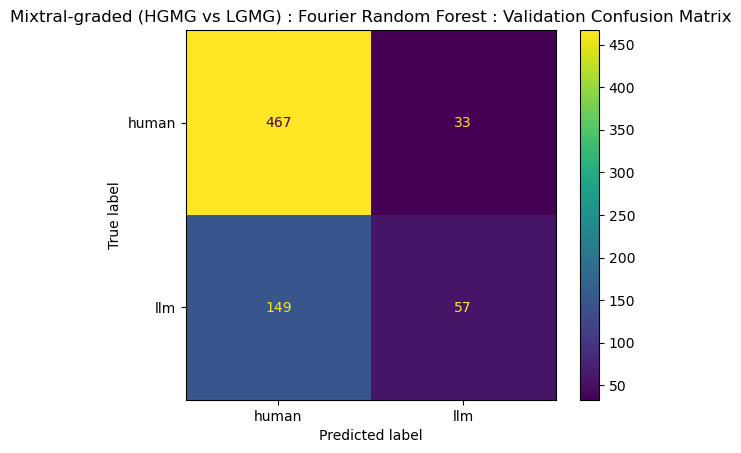

spectral_entropy_w64_mean     0.268806
spectral_entropy_w64_std      0.255218
spectral_entropy_w128_std     0.242223
spectral_entropy_w128_mean    0.233753
dtype: float64

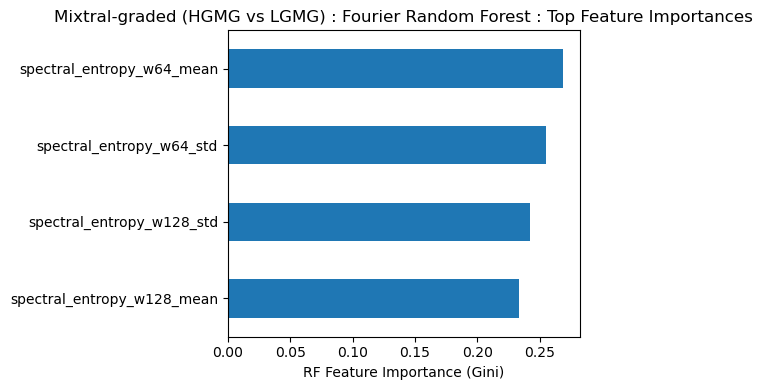

In [91]:
def model_eval_random_forest_subset(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    feature_cols: list[str],
    title: str = "",
):
    # Prepare design matrices
    X_train = train_df[feature_cols].copy().fillna(train_df[feature_cols].mean())
    X_val   = val_df[feature_cols].copy().fillna(train_df[feature_cols].mean())

    le = LabelEncoder()
    le.fit(train_df['label'])
    y_train = le.transform(train_df['label'])
    y_val   = le.transform(val_df['label'])

    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
    )
    rf.fit(X_train, y_train)

    y_val_pred = rf.predict(X_val)
    y_val_proba = rf.predict_proba(X_val)[:, 1]

    acc  = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='macro', zero_division=0)
    rec  = recall_score(y_val, y_val_pred, average='macro', zero_division=0)
    f1m  = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
    auroc = roc_auc_score(y_val, y_val_proba)

    print(f"{title}")
    print("="*len(title))
    print(f"accuracy (val):        {acc:.3f}")
    print(f"precision_macro (val): {prec:.3f}")
    print(f"recall_macro (val):    {rec:.3f}")
    print(f"f1_macro (val):        {f1m:.3f}")
    print(f"AUROC (val):           {auroc:.3f}")

    cm = confusion_matrix(y_val, y_val_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform([0,1]))
    disp.plot(values_format='d')
    plt.title(f'{title} : Validation Confusion Matrix')
    plt.show()

    importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    display(importances.head(20))
    plt.figure(figsize=(6,4))
    importances.head(15).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.xlabel('RF Feature Importance (Gini)')
    plt.title(f'{title} : Top Feature Importances')
    plt.tight_layout()
    plt.show()

    return {
        'model': rf,
        'feature_cols': feature_cols,
        'label_encoder': le,
        'val_predictions': y_val_pred,
        'val_truth': y_val,
        'val_proba': y_val_proba,
        'val_feature_importances': importances,
    }

rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=entropy_features,
    title='Mixtral-graded (HGMG vs LGMG) : Fourier Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Mixtral-graded (HGMG vs LGMG) : All Features Random Forest
accuracy (val):        0.772
precision_macro (val): 0.741
recall_macro (val):    0.659
f1_macro (val):        0.675
AUROC (val):           0.799


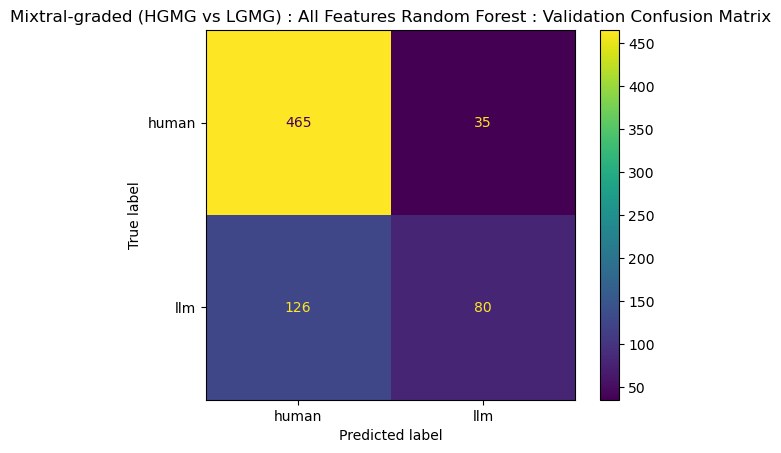

spectral_flatness_w64_std            0.103652
spectral_flatness_w128_mean          0.091807
spectral_flatness_w64_mean           0.069113
spectral_flatness_w128_std           0.060506
spectral_entropy_w64_mean            0.043742
spectral_entropy_w128_mean           0.036017
spectral_centroid_w64_std            0.033794
spectral_centroid_w128_mean          0.030664
spectral_entropy_w64_std             0.030282
fft_energy_ratio_cut0.50_w128_std    0.029921
spectral_entropy_w128_std            0.029699
fft_energy_ratio_cut0.90_w128_std    0.029141
spectral_slope_w128_mean             0.029034
spectral_slope_w64_mean              0.028840
fft_energy_ratio_cut0.50_w64_std     0.028013
fft_energy_ratio_cut0.90_w64_mean    0.027573
spectral_slope_w64_std               0.026564
spectral_centroid_w128_std           0.026213
fft_energy_ratio_cut0.75_w64_mean    0.026088
fft_energy_ratio_cut0.75_w128_std    0.025836
dtype: float64

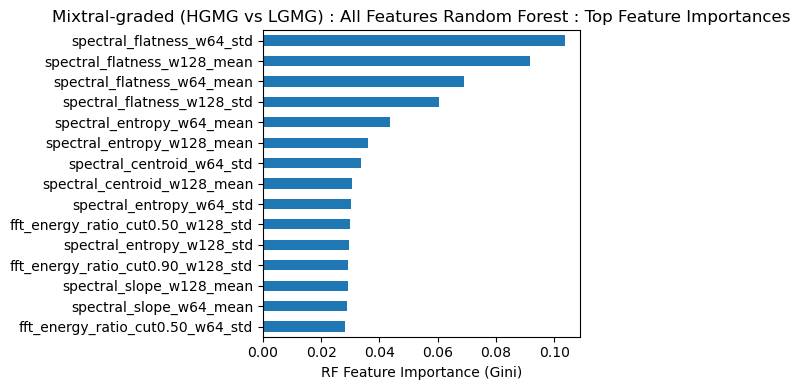

In [92]:
entropy_features = [c for c in df_mixtral.columns if c.startswith('spectral_entropy')]
centroid_features = [c for c in df_mixtral.columns if c.startswith('spectral_centroid')]
flatness_features = [c for c in df_mixtral.columns if c.startswith('spectral_flatness')]
slope_features = [c for c in df_mixtral.columns if c.startswith('spectral_slope')]
fft_energy_features = [c for c in df_mixtral.columns if c.startswith('fft_energy')]

all_features = entropy_features + centroid_features + flatness_features + slope_features + fft_energy_features
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Mixtral-graded (HGMG vs LGMG) : All Features Random Forest'
)

## RESULTS (Reuters Llama-Generated, Mixtral-Graded)
**0.675 F1 score** on Reuters Llama-Generated, Mixtral-Graded.  Not very good.

# <a color="red"><u>REUTERS</u></a>

## Mixtral-Generated, Llama-Graded

## Build Fourier-Only Feature DataFrame (HGMG vs LGMG)

We now build a dataframe of features for:

- Human-generated, Llama-graded (HGLG) Reuters documents
- Mixtral-generated, Llama-graded (MGLG) Reuters documents 


In [93]:
# Build the core dataframe for HGMG vs LGMG
df_llama = build_feature_df(HUMAN_REUTERS_LLAMA, LLM_REUTERS_MIXTRAL_LLAMA)
df_llama.head()


,num_windows,fft_energy_ratio_cut0.50_w64_mean,fft_energy_ratio_cut0.50_w64_std,fft_energy_ratio_cut0.75_w64_mean,fft_energy_ratio_cut0.75_w64_std,fft_energy_ratio_cut0.90_w64_mean,fft_energy_ratio_cut0.90_w64_std,spectral_centroid_w64_mean,spectral_centroid_w64_std,spectral_slope_w64_mean,...,spectral_centroid_w128_mean,spectral_centroid_w128_std,spectral_slope_w128_mean,spectral_slope_w128_std,spectral_entropy_w128_mean,spectral_entropy_w128_std,spectral_flatness_w128_mean,spectral_flatness_w128_std,label,doc_id
0,9.0,0.512335,0.092655,0.261635,0.090204,0.135485,0.074102,16.473592,2.042385,0.174260,...,32.798578,3.028851,0.045432,0.006649,0.895936,0.018296,0.564981,0.075989,human,human_0
1,12.0,0.526206,0.070238,0.289148,0.064320,0.129578,0.054796,16.096801,1.255145,0.169896,...,32.176749,2.444522,0.045330,0.006160,0.900937,0.009383,0.570427,0.033723,human,human_1
2,1.0,0.534724,0.000000,0.203461,0.000000,0.069214,0.000000,15.269744,0.000000,0.167816,...,22.127585,0.000000,0.104171,0.000000,0.903380,0.000000,0.124687,0.000000,human,human_2
3,14.0,0.528375,0.119681,0.277718,0.075849,0.124149,0.062352,16.492755,1.983669,0.171882,...,33.297301,2.405340,0.051909,0.008667,0.903511,0.016799,0.593417,0.044975,human,human_3
4,10.0,0.540472,0.104200,0.276232,0.083492,0.123523,0.055243,16.608507,1.589580,0.173423,...,32.906403,1.175205,0.048241,0.006434,0.901609,0.014524,0.587024,0.055246,human,human_4


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


In [94]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_llama, test_size=0.2, seed=42)

# Run threshold search for each flatness feature
flatness_results = []
for feat in flatness_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    flatness_results.append(res.__dict__)

flatness_results_df = pd.DataFrame(flatness_results).sort_values('val_f1_macro', ascending=False)
flatness_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,spectral_flatness_w64_mean,<=,0.597991,False,0.723358,0.661229,0.577726,0.321900,0.826234,0.574067,0.392676,0.736011,0.685634,0.599593,0.374150,0.832727,0.603438,0.384404
3,spectral_flatness_w128_std,>=,0.001081,False,0.718694,0.744382,0.528775,0.121076,0.832550,0.476813,0.450366,0.718795,0.727566,0.529065,0.125000,0.832479,0.478739,0.472159
1,spectral_flatness_w64_std,>=,0.002270,False,0.720488,0.803983,0.528279,0.111745,0.834149,0.472947,0.414079,0.720230,0.816727,0.525813,0.101382,0.834325,0.467854,0.419577
2,spectral_flatness_w128_mean,>=,0.457288,False,0.718694,0.715029,0.532314,0.140351,0.831832,0.486091,0.463292,0.710187,0.642963,0.520122,0.106195,0.827055,0.466625,0.445499


In [95]:
# Run threshold search for each fft_energy feature
fft_energy_results = []
for feat in fft_energy_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    fft_energy_results.append(res.__dict__)

fft_energy_results_df = pd.DataFrame(fft_energy_results).sort_values('val_f1_macro', ascending=False)
fft_energy_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
7,fft_energy_ratio_cut0.50_w128_std,>=,0.001391,False,0.719053,0.746124,0.529384,0.123180,0.832728,0.477954,0.514143,0.718795,0.727566,0.529065,0.125000,0.832479,0.478739,0.510599
9,fft_energy_ratio_cut0.75_w128_std,>=,0.003609,False,0.719053,0.746124,0.529384,0.123180,0.832728,0.477954,0.527602,0.718795,0.727566,0.529065,0.125000,0.832479,0.478739,0.552389
11,fft_energy_ratio_cut0.90_w128_std,>=,0.000616,False,0.718694,0.744382,0.528775,0.121076,0.832550,0.476813,0.548890,0.718795,0.727566,0.529065,0.125000,0.832479,0.478739,0.538162
1,fft_energy_ratio_cut0.50_w64_std,>=,0.001658,False,0.720488,0.803983,0.528279,0.111745,0.834149,0.472947,0.527621,0.720230,0.816727,0.525813,0.101382,0.834325,0.467854,0.496723
3,fft_energy_ratio_cut0.75_w64_std,>=,0.000684,False,0.720129,0.802842,0.527670,0.109589,0.833972,0.471780,0.519895,0.720230,0.816727,0.525813,0.101382,0.834325,0.467854,0.522254
5,fft_energy_ratio_cut0.90_w64_std,>=,0.000785,False,0.720129,0.802842,0.527670,0.109589,0.833972,0.471780,0.540525,0.720230,0.816727,0.525813,0.101382,0.834325,0.467854,0.505042
6,fft_energy_ratio_cut0.50_w128_mean,>=,0.412163,False,0.715465,0.767967,0.520470,0.085352,0.831528,0.458440,0.516812,0.713056,0.720050,0.516463,0.074074,0.830221,0.452147,0.526641
0,fft_energy_ratio_cut0.50_w64_mean,>=,0.428839,False,0.714029,0.766516,0.517684,0.074332,0.830893,0.452613,0.510073,0.708752,0.647141,0.511992,0.064516,0.827528,0.446022,0.517500
4,fft_energy_ratio_cut0.90_w64_mean,>=,0.073918,False,0.710800,0.730172,0.512563,0.056206,0.829237,0.442722,0.514777,0.705882,0.604440,0.507114,0.046512,0.826124,0.436318,0.468045
8,fft_energy_ratio_cut0.75_w128_mean,>=,0.169710,False,0.711159,0.789703,0.511402,0.047337,0.829774,0.438556,0.510114,0.710187,0.754769,0.508740,0.038095,0.829392,0.433744,0.479358


In [96]:
# Run threshold search for each entropy feature
entropy_results = []
for feat in entropy_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    entropy_results.append(res.__dict__)

entropy_results_df = pd.DataFrame(entropy_results).sort_values('val_f1_macro', ascending=False)
entropy_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,spectral_entropy_w64_mean,<=,0.886245,False,0.726947,0.692267,0.561872,0.256109,0.832784,0.544447,0.369828,0.730273,0.704019,0.564228,0.259843,0.835088,0.547465,0.392772
3,spectral_entropy_w128_std,>=,0.000264,False,0.718694,0.744382,0.528775,0.121076,0.832550,0.476813,0.466618,0.718795,0.727566,0.529065,0.125000,0.832479,0.478739,0.476740
2,spectral_entropy_w128_mean,<=,0.908154,False,0.711877,0.670450,0.521464,0.104794,0.828309,0.466551,0.436072,0.723099,0.823729,0.530691,0.118721,0.835745,0.477233,0.430190
1,spectral_entropy_w64_std,>=,0.000537,False,0.720129,0.802842,0.527670,0.109589,0.833972,0.471780,0.457884,0.720230,0.816727,0.525813,0.101382,0.834325,0.467854,0.457035


## All Features

Now we repeat the same procedure using **All features**.


Mixtral-Generated, Llama-Graded (HGLG vs MGLG) : All Features Random Forest
accuracy (val):        0.782
precision_macro (val): 0.761
recall_macro (val):    0.673
f1_macro (val):        0.692
AUROC (val):           0.746


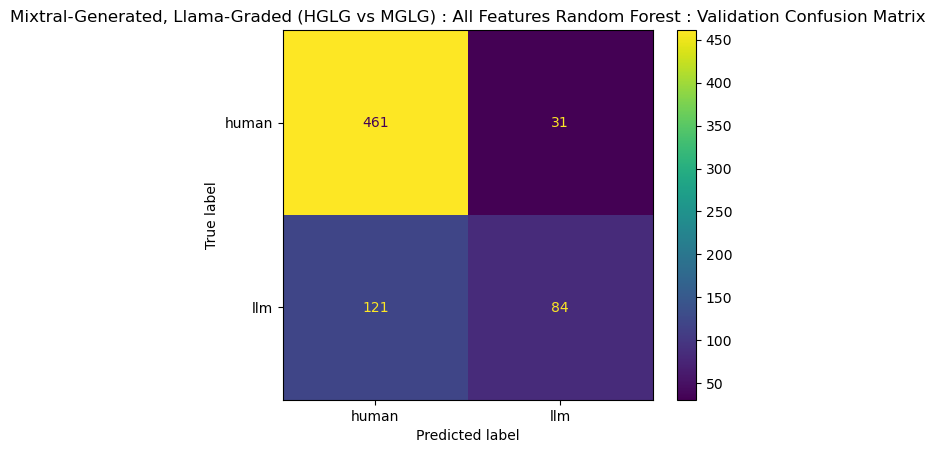

spectral_entropy_w64_mean             0.069637
spectral_flatness_w64_std             0.064679
spectral_flatness_w64_mean            0.064367
spectral_flatness_w128_std            0.048733
spectral_flatness_w128_mean           0.045080
spectral_entropy_w128_std             0.043855
spectral_entropy_w64_std              0.038697
spectral_entropy_w128_mean            0.036314
spectral_centroid_w128_mean           0.036057
spectral_centroid_w128_std            0.033552
fft_energy_ratio_cut0.75_w64_std      0.032854
spectral_slope_w64_std                0.032559
spectral_centroid_w64_std             0.032436
fft_energy_ratio_cut0.50_w64_std      0.032220
fft_energy_ratio_cut0.90_w128_std     0.032042
spectral_slope_w128_mean              0.031195
spectral_slope_w64_mean               0.030572
fft_energy_ratio_cut0.90_w64_std      0.030444
fft_energy_ratio_cut0.50_w128_mean    0.028976
fft_energy_ratio_cut0.90_w128_mean    0.027402
dtype: float64

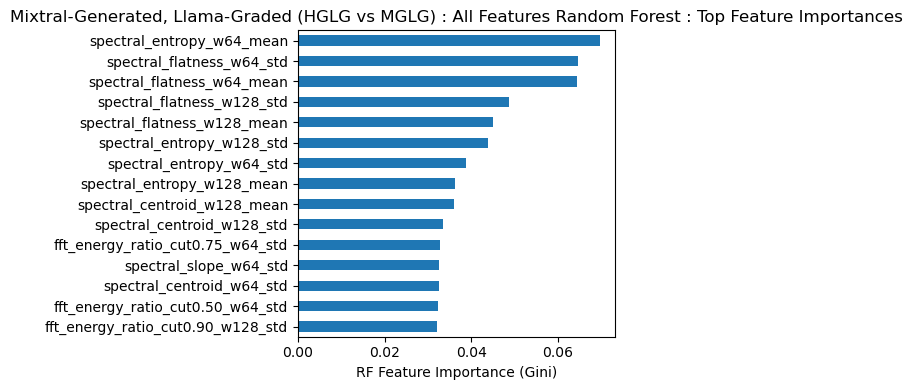

In [97]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Mixtral-Generated, Llama-Graded (HGLG vs MGLG) : All Features Random Forest'
)

## RESULTS (Reuters Mixtral-Generated, Llama-Graded)
0.692 F1 score for Mixtral-Generated, Llama-Graded.  Poor separation.

# Llama-Generated, Llama-Graded (SAME MODEL) Reuters

## Build Fourier-Only Feature DataFrame (HGLG vs LGLG)

We now build a dataframe of features for:

- Human-generated, Llama-graded (HGLG) Reuters documents
- Mixtral-generated, Llama-graded (LGLG) Reuters documents 


In [98]:
# Build the core dataframe for HGMG vs LGMG
df_llama = build_feature_df(HUMAN_REUTERS_LLAMA, LLM_REUTERS_LLAMA_LLAMA)
df_llama.head()


,num_windows,fft_energy_ratio_cut0.50_w64_mean,fft_energy_ratio_cut0.50_w64_std,fft_energy_ratio_cut0.75_w64_mean,fft_energy_ratio_cut0.75_w64_std,fft_energy_ratio_cut0.90_w64_mean,fft_energy_ratio_cut0.90_w64_std,spectral_centroid_w64_mean,spectral_centroid_w64_std,spectral_slope_w64_mean,...,spectral_centroid_w128_mean,spectral_centroid_w128_std,spectral_slope_w128_mean,spectral_slope_w128_std,spectral_entropy_w128_mean,spectral_entropy_w128_std,spectral_flatness_w128_mean,spectral_flatness_w128_std,label,doc_id
0,9.0,0.512335,0.092655,0.261635,0.090204,0.135485,0.074102,16.473592,2.042385,0.174260,...,32.798578,3.028851,0.045432,0.006649,0.895936,0.018296,0.564981,0.075989,human,human_0
1,12.0,0.526206,0.070238,0.289148,0.064320,0.129578,0.054796,16.096801,1.255145,0.169896,...,32.176749,2.444522,0.045330,0.006160,0.900937,0.009383,0.570427,0.033723,human,human_1
2,1.0,0.534724,0.000000,0.203461,0.000000,0.069214,0.000000,15.269744,0.000000,0.167816,...,22.127585,0.000000,0.104171,0.000000,0.903380,0.000000,0.124687,0.000000,human,human_2
3,14.0,0.528375,0.119681,0.277718,0.075849,0.124149,0.062352,16.492755,1.983669,0.171882,...,33.297301,2.405340,0.051909,0.008667,0.903511,0.016799,0.593417,0.044975,human,human_3
4,10.0,0.540472,0.104200,0.276232,0.083492,0.123523,0.055243,16.608507,1.589580,0.173423,...,32.906403,1.175205,0.048241,0.006434,0.901609,0.014524,0.587024,0.055246,human,human_4


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## Deep Dive: Threshold Search and Random Forest

We now isolate **Fourier features** and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these features.


In [99]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_llama, test_size=0.2, seed=42)

flatness_results = []
for feat in flatness_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    flatness_results.append(res.__dict__)

flatness_results_df = pd.DataFrame(flatness_results).sort_values('val_f1_macro', ascending=False)
flatness_results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,spectral_flatness_w64_mean,<=,0.598317,False,0.682788,0.722226,0.626357,0.447699,0.777497,0.612598,0.371340,0.662665,0.680727,0.606877,0.420619,0.762066,0.591342,0.369728
3,spectral_flatness_w128_std,<=,0.074547,False,0.640132,0.672668,0.573183,0.315429,0.755909,0.535669,0.492413,0.653061,0.681149,0.591097,0.370370,0.760563,0.565467,0.449288
1,spectral_flatness_w64_std,<=,0.097952,False,0.642836,0.658420,0.581528,0.356950,0.752755,0.554852,0.436576,0.644658,0.669218,0.580833,0.345133,0.756178,0.550655,0.445849
2,spectral_flatness_w128_mean,>=,0.531247,False,0.632923,0.655521,0.565619,0.300915,0.751120,0.526018,0.518747,0.645858,0.682190,0.579599,0.331066,0.759184,0.545125,0.522137


In [100]:
results = []
for feat in centroid_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
2,spectral_centroid_w128_mean,>=,30.511620,False,0.777411,0.777163,0.756626,0.702529,0.822174,0.762352,0.816155,0.779112,0.774821,0.763056,0.714286,0.819961,0.767123,0.838781
0,spectral_centroid_w64_mean,>=,15.494748,False,0.750676,0.757021,0.720750,0.645904,0.807603,0.726754,0.785743,0.770708,0.778328,0.742892,0.677909,0.821994,0.749952,0.814623
1,spectral_centroid_w64_std,<=,1.906678,False,0.688795,0.688563,0.650730,0.536673,0.765717,0.651195,0.317963,0.671068,0.665246,0.632442,0.510714,0.752260,0.631487,0.318092
3,spectral_centroid_w128_std,<=,3.014874,False,0.667768,0.701774,0.608926,0.411076,0.768619,0.589847,0.366706,0.644658,0.680394,0.578133,0.327273,0.758564,0.542919,0.358934


Llama-Generated, Llama-Graded (HGLG vs LGLG) : Fourier Spectrum Entropy Random Forest
accuracy (val):        0.745
precision_macro (val): 0.741
recall_macro (val):    0.724
f1_macro (val):        0.728
AUROC (val):           0.788


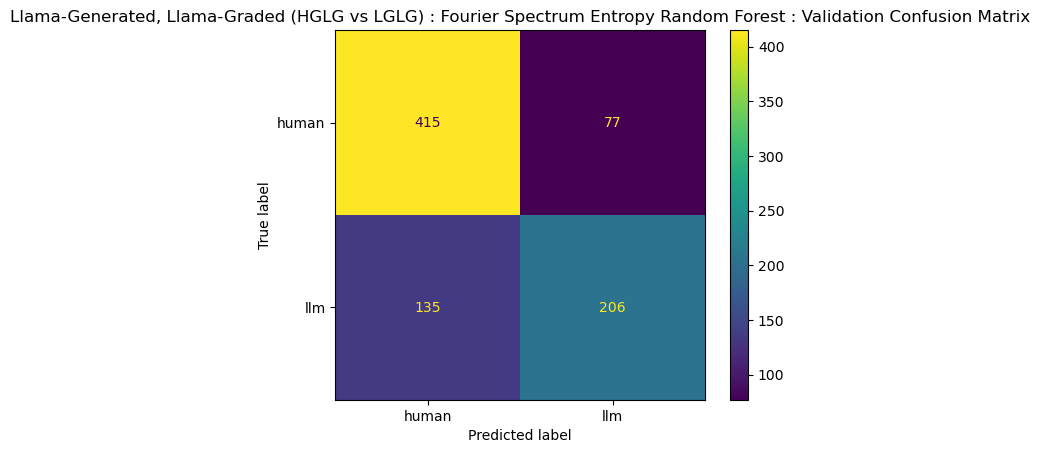

spectral_entropy_w64_mean     0.340678
spectral_entropy_w128_mean    0.238248
spectral_entropy_w128_std     0.221002
spectral_entropy_w64_std      0.200072
dtype: float64

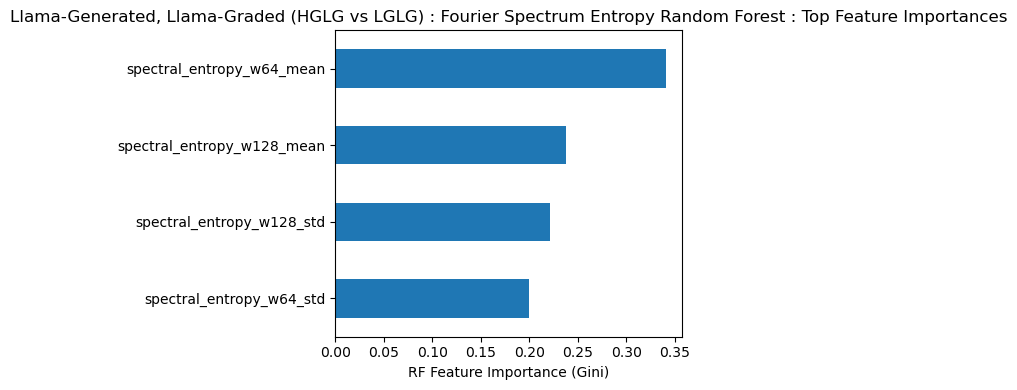

In [101]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=entropy_features,
    title='Llama-Generated, Llama-Graded (HGLG vs LGLG) : Fourier Spectrum Entropy Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Llama-Generated, Llama-Graded (HGLG vs LGLG) : All Features Random Forest
accuracy (val):        0.884
precision_macro (val): 0.883
recall_macro (val):    0.875
f1_macro (val):        0.878
AUROC (val):           0.957


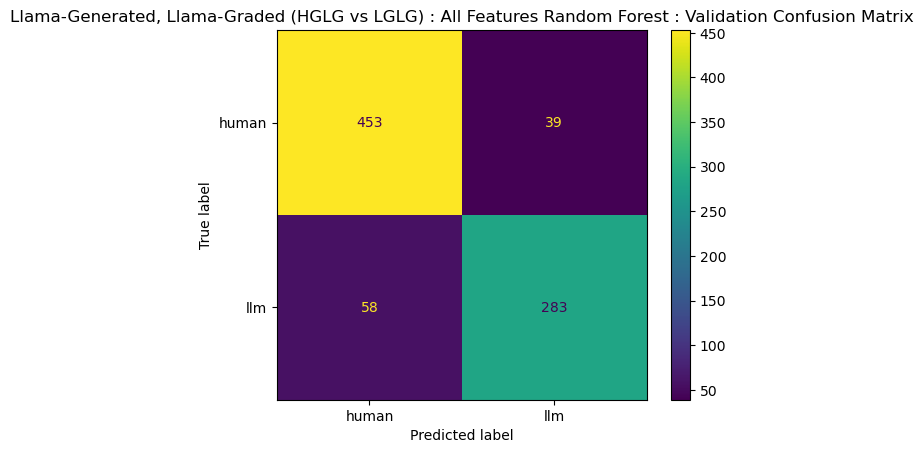

spectral_centroid_w128_mean           0.128644
spectral_slope_w64_mean               0.113844
spectral_entropy_w64_mean             0.094756
spectral_slope_w128_mean              0.078456
spectral_flatness_w64_mean            0.058230
spectral_centroid_w64_mean            0.052528
spectral_centroid_w64_std             0.035094
fft_energy_ratio_cut0.50_w128_mean    0.034548
fft_energy_ratio_cut0.50_w64_mean     0.031067
spectral_centroid_w128_std            0.030266
spectral_flatness_w128_std            0.028436
spectral_entropy_w128_mean            0.026171
fft_energy_ratio_cut0.75_w64_mean     0.025483
fft_energy_ratio_cut0.75_w128_mean    0.024788
spectral_flatness_w128_mean           0.019978
fft_energy_ratio_cut0.90_w128_mean    0.019945
fft_energy_ratio_cut0.75_w64_std      0.019571
spectral_entropy_w128_std             0.019274
spectral_flatness_w64_std             0.018594
spectral_slope_w128_std               0.018400
dtype: float64

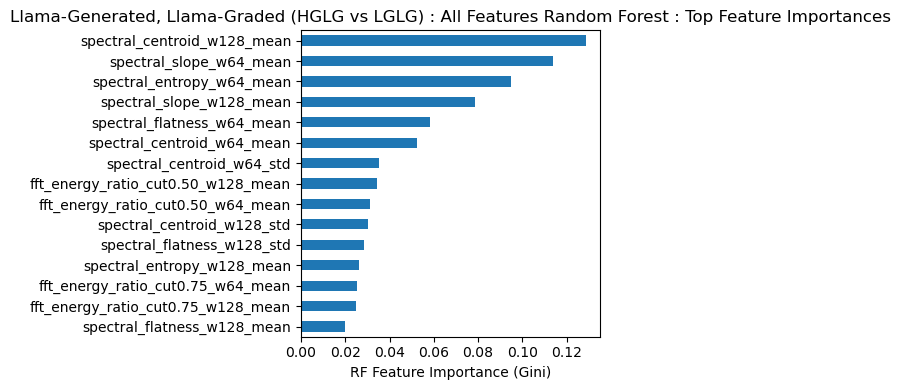

In [102]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Llama-Generated, Llama-Graded (HGLG vs LGLG) : All Features Random Forest'
)

## RESULTS (Reuters Mixtral-Generated, Llama-Graded)
0.878 F1 score for Mixtral-Generated, Llama-Graded.  Separation is *okay*, but this is only for the same model evalutation.

# <a color="red"><u>HC3</u></a>

## Llama-Graded

## Build Fourier-Only Feature DataFrame

We now build a dataframe of features for HC3 Llama-Graded:


In [103]:
# Build the core dataframe for HGMG vs LGMG
df_llama = build_feature_df(HUMAN_HC3_LLAMA, LLM_HC3_LLAMA)
df_llama.head()


,num_windows,fft_energy_ratio_cut0.50_w64_mean,fft_energy_ratio_cut0.50_w64_std,fft_energy_ratio_cut0.75_w64_mean,fft_energy_ratio_cut0.75_w64_std,fft_energy_ratio_cut0.90_w64_mean,fft_energy_ratio_cut0.90_w64_std,spectral_centroid_w64_mean,spectral_centroid_w64_std,spectral_slope_w64_mean,...,spectral_centroid_w128_mean,spectral_centroid_w128_std,spectral_slope_w128_mean,spectral_slope_w128_std,spectral_entropy_w128_mean,spectral_entropy_w128_std,spectral_flatness_w128_mean,spectral_flatness_w128_std,label,doc_id
0,5.0,0.502050,0.097177,0.254721,0.097937,0.078348,0.040422,15.497694,1.874820,0.153213,...,30.624403,2.323791,0.045733,0.007945,0.884198,0.014958,0.543953,0.035286,human,human_0
1,7.0,0.502844,0.071919,0.239405,0.055481,0.109012,0.041379,15.949651,1.582745,0.169147,...,31.757541,2.675781,0.042915,0.008001,0.908423,0.010931,0.597188,0.061442,human,human_1
2,6.0,0.546427,0.087528,0.333713,0.057641,0.135310,0.055001,16.615711,1.768975,0.170671,...,32.164266,1.440190,0.044204,0.003879,0.894555,0.017976,0.544417,0.045611,human,human_2
3,7.0,0.469215,0.073877,0.180603,0.059817,0.091660,0.063233,14.473324,2.027993,0.153650,...,29.602657,2.573406,0.036400,0.008047,0.884128,0.016472,0.533869,0.054571,human,human_3
4,6.0,0.515701,0.025506,0.224004,0.040995,0.072676,0.030649,15.874238,0.678975,0.161217,...,31.390658,0.563312,0.041455,0.003322,0.902520,0.006968,0.576456,0.045832,human,human_4


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## Feature Deep Dive: Threshold Search and Random Forest

We now isolate **features** and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these features.


In [104]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_llama, test_size=0.2, seed=42)

# Run threshold search for each feature
results = []
for feat in flatness_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
3,spectral_flatness_w128_std,<=,0.011924,False,0.687963,0.779343,0.723528,0.731863,0.626876,0.679369,0.275582,0.683970,0.778488,0.720303,0.729492,0.620027,0.674760,0.279610
2,spectral_flatness_w128_mean,<=,0.563296,False,0.627924,0.620845,0.620759,0.568832,0.672771,0.620801,0.302926,0.638905,0.632663,0.633254,0.586004,0.679818,0.632911,0.290604
1,spectral_flatness_w64_std,<=,0.043782,False,0.624929,0.704582,0.660453,0.679971,0.547020,0.613496,0.308292,0.630348,0.709419,0.665665,0.683594,0.555556,0.619575,0.303047
0,spectral_flatness_w64_mean,<=,0.590120,False,0.618654,0.609006,0.592990,0.477938,0.699618,0.588778,0.330153,0.632059,0.623789,0.608845,0.507257,0.706418,0.606838,0.304567


In [105]:
results = []
for feat in centroid_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
3,spectral_centroid_w128_std,<=,1.707447,False,0.708214,0.704198,0.706799,0.673476,0.736272,0.704874,0.200574,0.711922,0.707343,0.709398,0.674404,0.741688,0.708046,0.195466
1,spectral_centroid_w64_std,<=,1.697014,False,0.660867,0.656342,0.639546,0.551490,0.727356,0.639423,0.255707,0.660582,0.659024,0.635530,0.534793,0.732824,0.633809,0.250387
2,spectral_centroid_w128_mean,<=,27.332999,False,0.627353,0.715060,0.664324,0.684763,0.544377,0.614570,0.353517,0.626355,0.722576,0.665003,0.686753,0.537102,0.611928,0.364029
0,spectral_centroid_w64_mean,>=,1.226876,True,0.567884,0.283942,0.500000,0.000000,0.724395,0.362198,0.422067,0.568169,0.284084,0.500000,0.000000,0.724627,0.362314,0.429127


Llama-Graded HC3 : Spectral Centroid Random Forest
accuracy (val):        0.734
precision_macro (val): 0.732
recall_macro (val):    0.736
f1_macro (val):        0.732
AUROC (val):           0.821


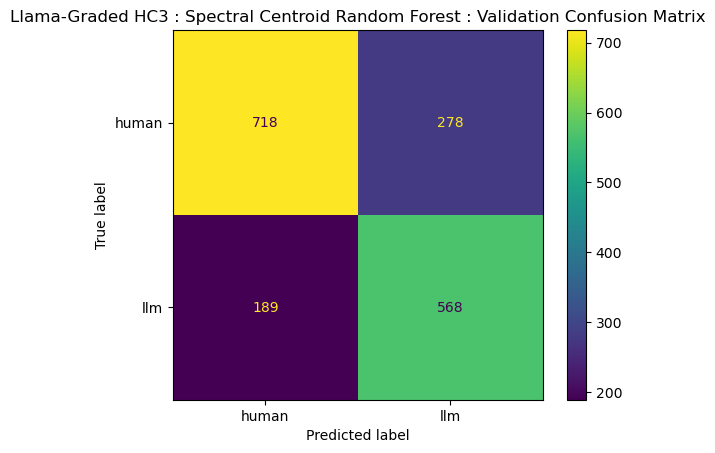

spectral_centroid_w128_std     0.375977
spectral_centroid_w64_std      0.258301
spectral_centroid_w128_mean    0.208984
spectral_centroid_w64_mean     0.156739
dtype: float64

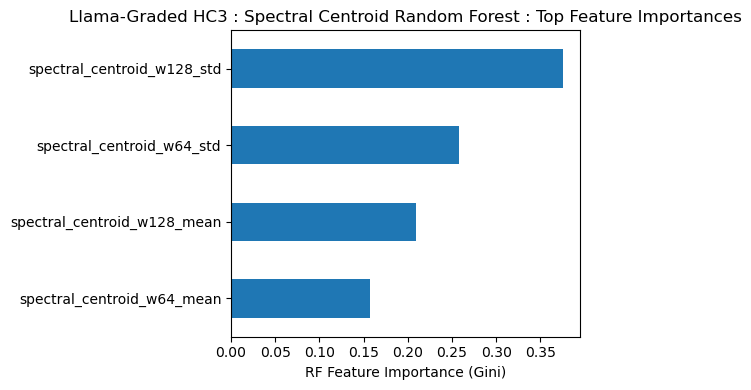

In [106]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=centroid_features,
    title='Llama-Graded HC3 : Spectral Centroid Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Llama-Graded HC3 : All Features Random Forest
accuracy (val):        0.846
precision_macro (val): 0.845
recall_macro (val):    0.851
f1_macro (val):        0.845
AUROC (val):           0.927


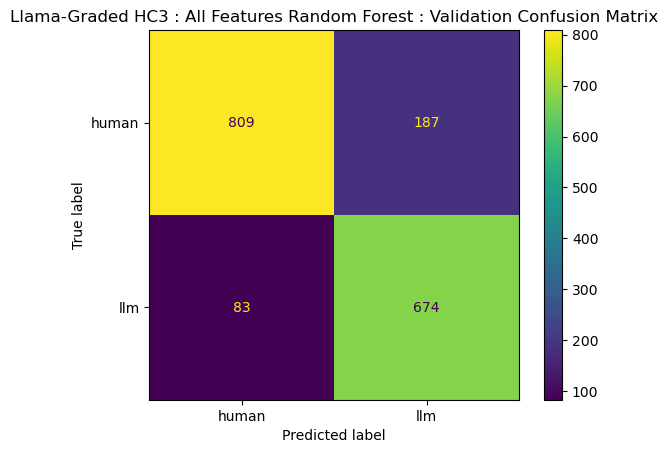

spectral_centroid_w128_std            0.087541
spectral_slope_w64_mean               0.083470
fft_energy_ratio_cut0.75_w128_std     0.065735
spectral_entropy_w64_mean             0.055558
fft_energy_ratio_cut0.50_w128_std     0.054678
spectral_slope_w128_std               0.052772
spectral_flatness_w128_std            0.052637
fft_energy_ratio_cut0.90_w128_std     0.044812
spectral_slope_w128_mean              0.043068
spectral_entropy_w128_std             0.033504
spectral_flatness_w64_mean            0.032697
spectral_centroid_w64_std             0.031352
fft_energy_ratio_cut0.75_w64_mean     0.029586
fft_energy_ratio_cut0.90_w64_std      0.029099
spectral_entropy_w128_mean            0.025755
fft_energy_ratio_cut0.90_w64_mean     0.025028
fft_energy_ratio_cut0.75_w128_mean    0.023664
spectral_flatness_w128_mean           0.023212
fft_energy_ratio_cut0.75_w64_std      0.022841
fft_energy_ratio_cut0.50_w64_mean     0.022043
dtype: float64

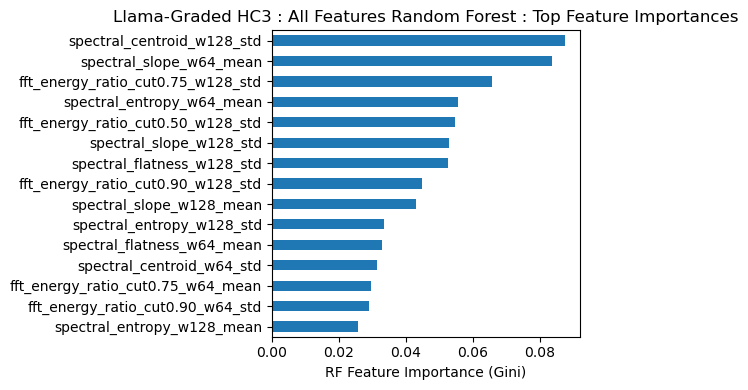

In [107]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Llama-Graded HC3 : All Features Random Forest'
)

## RESULTS (HC3, Llama-Graded)
0.845 F1 score.  Okay separation.

# <a color="red"><u>HC3</u></a>

## Mixtral-Graded

## Build Fourier-Only Feature DataFrame

We now build a dataframe of features for HC3 Mixtral-Graded:


In [108]:
# Build the core dataframe for HGMG vs LGMG
df_mixtral = build_feature_df(HUMAN_HC3_MIXTRAL, LLM_HC3_MIXTRAL)
df_mixtral.head()


,num_windows,fft_energy_ratio_cut0.50_w64_mean,fft_energy_ratio_cut0.50_w64_std,fft_energy_ratio_cut0.75_w64_mean,fft_energy_ratio_cut0.75_w64_std,fft_energy_ratio_cut0.90_w64_mean,fft_energy_ratio_cut0.90_w64_std,spectral_centroid_w64_mean,spectral_centroid_w64_std,spectral_slope_w64_mean,...,spectral_centroid_w128_mean,spectral_centroid_w128_std,spectral_slope_w128_mean,spectral_slope_w128_std,spectral_entropy_w128_mean,spectral_entropy_w128_std,spectral_flatness_w128_mean,spectral_flatness_w128_std,label,doc_id
0,6.0,0.458328,0.082548,0.243893,0.090036,0.077457,0.023080,14.962242,1.506535,0.149753,...,29.399237,2.640812,0.037640,0.007920,0.898987,0.018843,0.573738,0.062794,human,human_0
1,9.0,0.528287,0.072225,0.295300,0.071844,0.146285,0.063457,16.593291,1.494801,0.179483,...,32.656720,1.293955,0.047117,0.006498,0.897500,0.013382,0.584831,0.055908,human,human_1
2,7.0,0.558350,0.092776,0.246888,0.068147,0.079348,0.030953,16.230084,1.475704,0.161152,...,32.328710,1.346762,0.047723,0.006435,0.903355,0.013590,0.583415,0.065622,human,human_2
3,8.0,0.487890,0.088429,0.199958,0.041852,0.122465,0.027165,15.164626,1.063797,0.163718,...,29.944843,1.277265,0.038559,0.005704,0.890375,0.010893,0.522826,0.044867,human,human_3
4,7.0,0.489089,0.039908,0.223750,0.054789,0.088891,0.034827,15.888431,0.644326,0.174352,...,31.387268,0.596005,0.043344,0.003642,0.891949,0.014742,0.560224,0.034127,human,human_4


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## Deep Dive: Threshold Search and Random Forest

We now isolate **features** and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these features.


In [109]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_mixtral, test_size=0.2, seed=42)

results = []
for feat in slope_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
1,spectral_slope_w64_std,<=,0.035178,False,0.685720,0.634188,0.524437,0.132125,0.808117,0.470121,0.332044,0.688400,0.642337,0.530272,0.155963,0.808930,0.482447,0.303974
3,spectral_slope_w128_std,<=,0.012234,False,0.688473,0.666313,0.523850,0.117541,0.810849,0.464195,0.287477,0.684166,0.628098,0.519480,0.109785,0.808029,0.458907,0.273805
0,spectral_slope_w64_mean,>=,0.054575,True,0.679263,0.339632,0.500000,0.000000,0.809002,0.404501,0.610933,0.679086,0.339687,0.499688,0.000000,0.808875,0.404438,0.635563
2,spectral_slope_w128_mean,>=,0.007611,True,0.679263,0.339632,0.500000,0.000000,0.809002,0.404501,0.654684,0.679086,0.339687,0.499688,0.000000,0.808875,0.404438,0.687084


In [110]:
results = []
for feat in flatness_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
1,spectral_flatness_w64_std,<=,0.138811,False,0.945485,0.946393,0.927559,0.911709,0.960570,0.936139,0.056700,0.948349,0.952420,0.928492,0.915512,0.962805,0.939159,0.050452
0,spectral_flatness_w64_mean,>=,0.460997,False,0.813380,0.788346,0.816033,0.738931,0.854790,0.796860,0.779983,0.820491,0.795555,0.823593,0.748219,0.860526,0.804372,0.786727
3,spectral_flatness_w128_std,<=,0.096621,False,0.844713,0.870414,0.772205,0.701890,0.895012,0.798451,0.228785,0.844623,0.872466,0.770857,0.699918,0.895173,0.797546,0.221954
2,spectral_flatness_w128_mean,>=,0.446740,False,0.739600,0.751309,0.787331,0.693954,0.773397,0.733675,0.659433,0.739627,0.752044,0.788171,0.694486,0.773146,0.733816,0.648446


Mixtral-Graded HC3 : Spectral Centroid Random Forest
accuracy (val):        0.972
precision_macro (val): 0.970
recall_macro (val):    0.966
f1_macro (val):        0.968
AUROC (val):           0.988


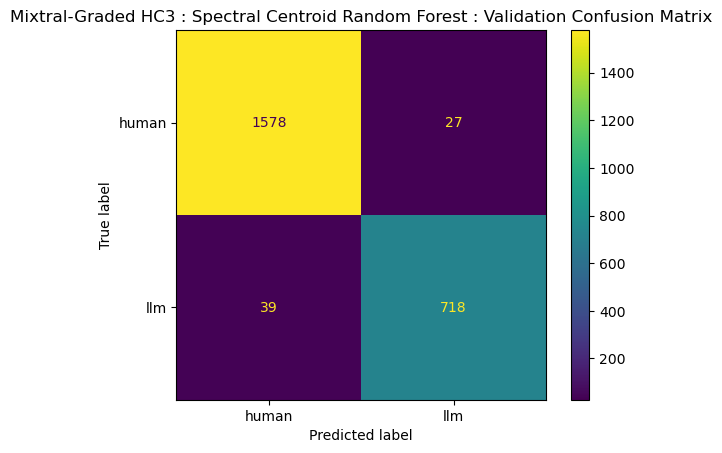

spectral_flatness_w64_std      0.542699
spectral_flatness_w128_std     0.246095
spectral_flatness_w64_mean     0.144242
spectral_flatness_w128_mean    0.066964
dtype: float64

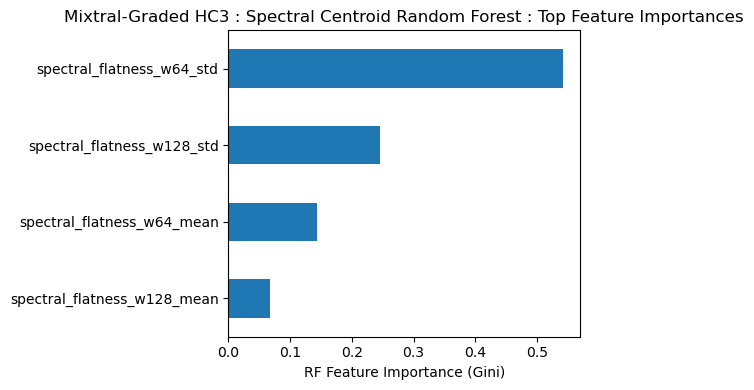

In [111]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=flatness_features,
    title='Mixtral-Graded HC3 : Spectral Centroid Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Mixtral-Graded HC3 : All Features Random Forest
accuracy (val):        0.977
precision_macro (val): 0.976
recall_macro (val):    0.971
f1_macro (val):        0.974
AUROC (val):           0.991


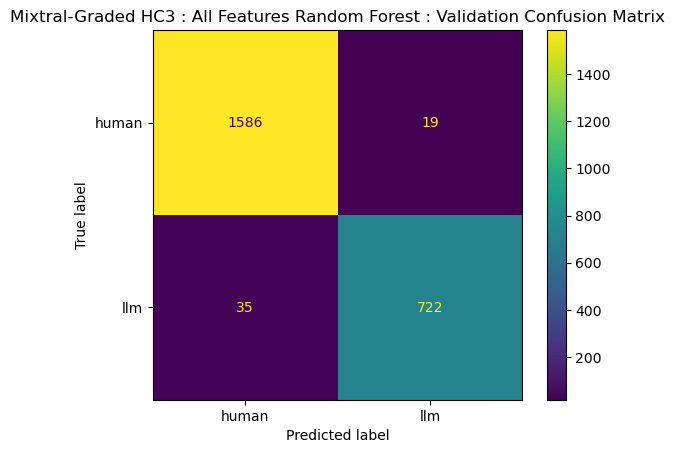

spectral_flatness_w64_std            0.272597
spectral_flatness_w128_mean          0.159458
spectral_flatness_w64_mean           0.125046
spectral_flatness_w128_std           0.118493
fft_energy_ratio_cut0.90_w128_std    0.047167
fft_energy_ratio_cut0.75_w128_std    0.039243
spectral_entropy_w128_std            0.032829
fft_energy_ratio_cut0.50_w128_std    0.029113
spectral_slope_w128_std              0.028216
spectral_entropy_w64_mean            0.027991
spectral_centroid_w128_std           0.019157
spectral_entropy_w128_mean           0.012569
spectral_slope_w128_mean             0.010186
spectral_centroid_w128_mean          0.009540
fft_energy_ratio_cut0.75_w64_std     0.009426
fft_energy_ratio_cut0.90_w64_std     0.008237
spectral_entropy_w64_std             0.005365
spectral_slope_w64_std               0.005221
spectral_centroid_w64_std            0.005191
spectral_slope_w64_mean              0.005063
dtype: float64

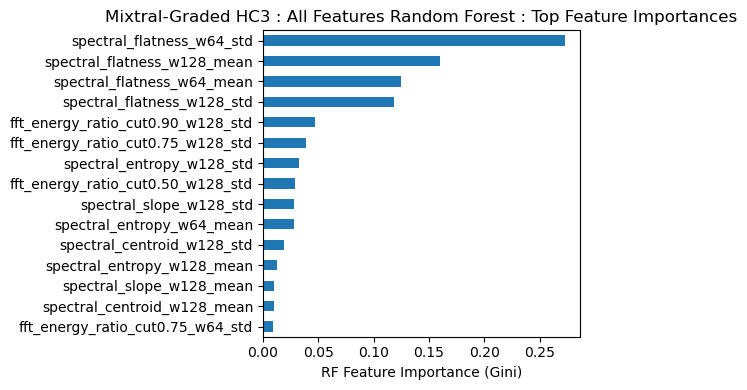

In [112]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Mixtral-Graded HC3 : All Features Random Forest'
)

## RESULTS (HC3, Mixtral-Graded)
0.974 F1 score.  Almost perfect separation.  Interesting that spectral flatness is so important (also the only feature with importance here).

# <a color="red"><u>MAGE</u></a>

## Llama-Graded

## Build Fourier-Only Feature DataFrame

We now build a dataframe of features for MAGE Llama-Graded:


In [113]:
# Build the core dataframe for HGMG vs LGMG
df_llama = build_feature_df(HUMAN_MAGE_LLAMA, LLM_MAGE_LLAMA)
df_llama.head()


,num_windows,fft_energy_ratio_cut0.50_w64_mean,fft_energy_ratio_cut0.50_w64_std,fft_energy_ratio_cut0.75_w64_mean,fft_energy_ratio_cut0.75_w64_std,fft_energy_ratio_cut0.90_w64_mean,fft_energy_ratio_cut0.90_w64_std,spectral_centroid_w64_mean,spectral_centroid_w64_std,spectral_slope_w64_mean,...,spectral_centroid_w128_mean,spectral_centroid_w128_std,spectral_slope_w128_mean,spectral_slope_w128_std,spectral_entropy_w128_mean,spectral_entropy_w128_std,spectral_flatness_w128_mean,spectral_flatness_w128_std,label,doc_id
0,5.0,0.550504,0.040098,0.315553,0.076564,0.146370,0.040483,16.824414,1.125630,0.177865,...,32.802391,2.416660,0.046103,0.004966,0.906532,0.002495,0.586414,0.020859,human,human_0
1,6.0,0.463132,0.093702,0.250337,0.070904,0.106775,0.047268,14.868196,2.054130,0.148678,...,28.805298,3.050046,0.033742,0.010507,0.901640,0.020590,0.590436,0.068296,human,human_1
2,6.0,0.566565,0.085149,0.291214,0.109555,0.158508,0.110579,17.078574,2.256917,0.165820,...,34.263798,2.763355,0.045553,0.006423,0.885665,0.025559,0.534083,0.057275,human,human_2
3,10.0,0.496187,0.092318,0.253580,0.049759,0.105303,0.044205,15.397889,1.661747,0.162276,...,30.618605,2.139643,0.039799,0.009772,0.897970,0.010445,0.557254,0.050967,human,human_3
4,10.0,0.506691,0.095548,0.311728,0.095605,0.127963,0.053570,16.302084,1.965944,0.173032,...,32.360324,2.133464,0.048140,0.007807,0.892492,0.017644,0.550394,0.056310,human,human_4


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## Feature Deep Dive: Threshold Search and Random Forest

We now isolate **features** and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these features.


In [114]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_llama, test_size=0.2, seed=42)

results = []
for feat in flatness_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
2,spectral_flatness_w128_mean,<=,0.548519,False,0.541667,0.556243,0.545087,0.622813,0.416035,0.519424,0.445740,0.542517,0.557835,0.545649,0.625869,0.411379,0.518624,0.440500
3,spectral_flatness_w128_std,>=,0.061562,False,0.535714,0.551787,0.539459,0.624484,0.391982,0.508233,0.533556,0.534014,0.550676,0.537491,0.626703,0.380090,0.503397,0.560345
0,spectral_flatness_w64_mean,<=,0.553356,False,0.529762,0.541968,0.533258,0.614634,0.396947,0.505790,0.475295,0.515306,0.522214,0.518202,0.598025,0.389722,0.493874,0.484321
1,spectral_flatness_w64_std,>=,0.086315,False,0.544218,0.558794,0.547574,0.623596,0.422414,0.523005,0.554039,0.515306,0.523601,0.518480,0.604716,0.373626,0.489171,0.540592


In [115]:
results = []
for feat in entropy_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
3,spectral_entropy_w128_std,>=,0.015231,False,0.572704,0.575360,0.573821,0.598482,0.543389,0.570936,0.574246,0.566327,0.568102,0.567149,0.588045,0.542190,0.565118,0.577528
2,spectral_entropy_w128_mean,<=,0.895404,False,0.564626,0.565069,0.564966,0.570470,0.558621,0.564545,0.415833,0.549320,0.549186,0.549167,0.540728,0.557596,0.549162,0.431416
1,spectral_entropy_w64_std,>=,0.028389,False,0.580357,0.601192,0.583572,0.650619,0.474721,0.562670,0.582298,0.562925,0.579726,0.565783,0.636492,0.452026,0.544259,0.590893
0,spectral_entropy_w64_mean,<=,0.869303,False,0.547194,0.559974,0.550284,0.620591,0.438587,0.529589,0.449175,0.542517,0.552216,0.545047,0.611833,0.443064,0.527448,0.443069


Llama-Graded MAGE : FFT Energy Fraction Random Forest
accuracy (val):        0.543
precision_macro (val): 0.544
recall_macro (val):    0.543
f1_macro (val):        0.542
AUROC (val):           0.577


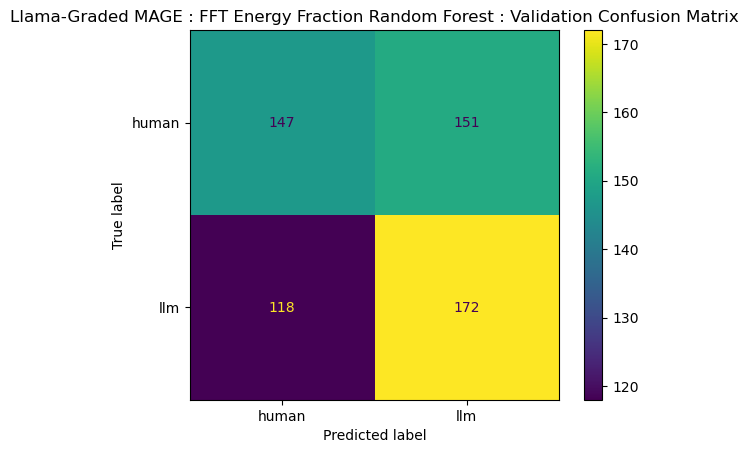

fft_energy_ratio_cut0.50_w128_std     0.094926
fft_energy_ratio_cut0.50_w128_mean    0.087281
fft_energy_ratio_cut0.75_w64_std      0.086247
fft_energy_ratio_cut0.75_w128_std     0.086067
fft_energy_ratio_cut0.50_w64_std      0.085967
fft_energy_ratio_cut0.50_w64_mean     0.085323
fft_energy_ratio_cut0.90_w128_std     0.082401
fft_energy_ratio_cut0.90_w64_std      0.081284
fft_energy_ratio_cut0.75_w64_mean     0.078843
fft_energy_ratio_cut0.75_w128_mean    0.078160
fft_energy_ratio_cut0.90_w64_mean     0.077440
fft_energy_ratio_cut0.90_w128_mean    0.076062
dtype: float64

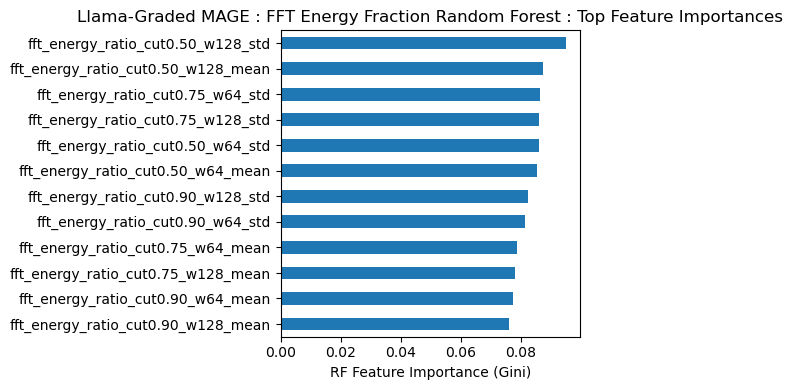

In [116]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=fft_energy_features,
    title='Llama-Graded MAGE : FFT Energy Fraction Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Llama-Graded MAGE : All Features Random Forest
accuracy (val):        0.602
precision_macro (val): 0.603
recall_macro (val):    0.603
f1_macro (val):        0.602
AUROC (val):           0.663


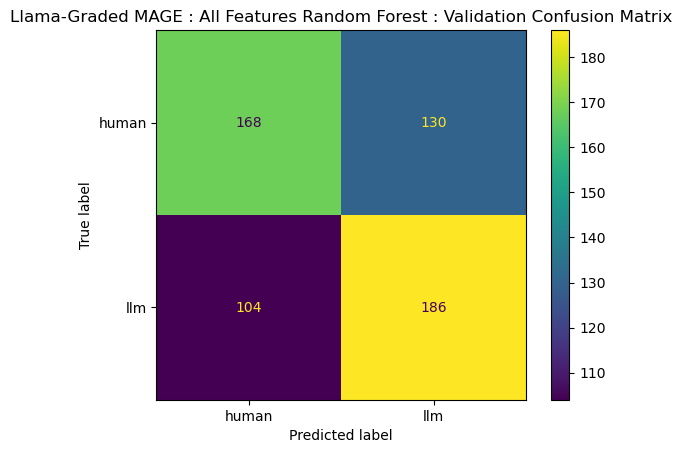

spectral_slope_w64_mean               0.050989
spectral_entropy_w128_std             0.050371
spectral_entropy_w64_std              0.048051
spectral_centroid_w128_std            0.046098
spectral_centroid_w64_std             0.042034
spectral_entropy_w128_mean            0.038875
spectral_slope_w128_mean              0.038426
spectral_slope_w64_std                0.037337
fft_energy_ratio_cut0.50_w128_std     0.036297
spectral_slope_w128_std               0.035558
fft_energy_ratio_cut0.75_w64_std      0.034915
spectral_flatness_w64_std             0.034409
fft_energy_ratio_cut0.50_w64_mean     0.033973
spectral_flatness_w128_mean           0.033281
fft_energy_ratio_cut0.50_w64_std      0.032940
spectral_flatness_w64_mean            0.032539
fft_energy_ratio_cut0.75_w128_std     0.032512
fft_energy_ratio_cut0.90_w128_std     0.032433
fft_energy_ratio_cut0.50_w128_mean    0.032343
fft_energy_ratio_cut0.75_w64_mean     0.032225
dtype: float64

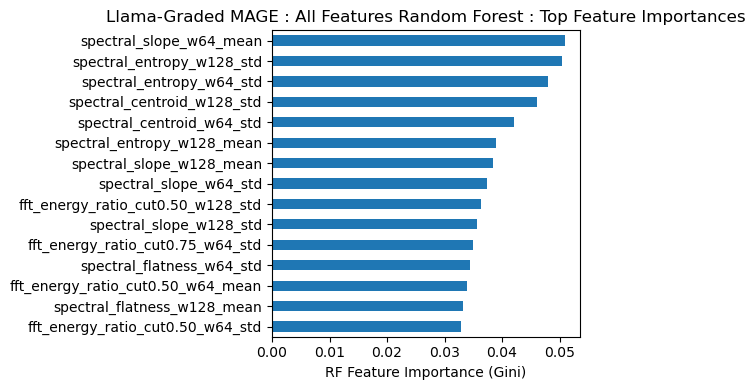

In [117]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Llama-Graded MAGE : All Features Random Forest'
)

## RESULTS (MAGE, Llama-Graded)
0.602 F1 score.  Variation of Differences appears to be most important

# <a color="red"><u>MAGE</u></a>

## Mixtral-Graded

## Build Fourier-Only Feature DataFrame

We now build a dataframe of features for MAGE Mixtral-Graded:


In [118]:
# Build the core dataframe for HGMG vs LGMG
df_mixtral = build_feature_df(HUMAN_MAGE_MIXTRAL, LLM_MAGE_MIXTRAL)
df_mixtral.head()


,num_windows,fft_energy_ratio_cut0.50_w64_mean,fft_energy_ratio_cut0.50_w64_std,fft_energy_ratio_cut0.75_w64_mean,fft_energy_ratio_cut0.75_w64_std,fft_energy_ratio_cut0.90_w64_mean,fft_energy_ratio_cut0.90_w64_std,spectral_centroid_w64_mean,spectral_centroid_w64_std,spectral_slope_w64_mean,...,spectral_centroid_w128_mean,spectral_centroid_w128_std,spectral_slope_w128_mean,spectral_slope_w128_std,spectral_entropy_w128_mean,spectral_entropy_w128_std,spectral_flatness_w128_mean,spectral_flatness_w128_std,label,doc_id
0,8.0,0.531348,0.049902,0.309703,0.104048,0.167119,0.088964,16.549765,1.191418,0.170869,...,31.639972,1.852147,0.043558,0.005016,0.884925,0.026063,0.439573,0.219035,human,human_0
1,5.0,0.494503,0.033341,0.239152,0.070355,0.109652,0.038250,15.326380,0.620691,0.143446,...,29.689941,0.861198,0.038723,0.003658,0.890444,0.010141,0.550171,0.050194,human,human_1
2,7.0,0.459384,0.106389,0.218741,0.063182,0.117507,0.043038,15.130651,1.690084,0.153366,...,29.266112,2.115725,0.037906,0.006802,0.909387,0.010051,0.382876,0.182103,human,human_2
3,7.0,0.508152,0.077581,0.301025,0.089021,0.154278,0.048983,16.632814,1.414832,0.170602,...,32.549857,2.269251,0.045119,0.009251,0.903685,0.016463,0.585525,0.080768,human,human_3
4,7.0,0.560691,0.072261,0.269386,0.087379,0.118414,0.057431,16.704208,1.089220,0.175458,...,32.546638,1.122007,0.046946,0.006930,0.892929,0.012700,0.551429,0.045974,human,human_4


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## Feature Deep Dive: Threshold Search and Random Forest

We now isolate **features** and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these features.


In [119]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_mixtral, test_size=0.2, seed=42)

results = []
for feat in centroid_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
3,spectral_centroid_w128_std,>=,2.718406,False,0.547174,0.576700,0.547236,0.654277,0.343923,0.499100,0.555287,0.547064,0.576088,0.546814,0.654389,0.343057,0.498723,0.555051
1,spectral_centroid_w64_std,>=,1.905513,False,0.536109,0.557131,0.536170,0.643916,0.334680,0.489298,0.531931,0.531778,0.548080,0.531542,0.638060,0.337130,0.487595,0.536299
2,spectral_centroid_w128_mean,<=,30.480782,False,0.523235,0.531435,0.523286,0.619949,0.360496,0.490223,0.496340,0.505229,0.506798,0.505024,0.606022,0.335135,0.470578,0.516862
0,spectral_centroid_w64_mean,>=,16.930505,False,0.523436,0.551111,0.523510,0.651464,0.246741,0.449102,0.504309,0.519710,0.539576,0.519423,0.646117,0.252816,0.449467,0.518337


Mixtral-Graded MAGE : Spectral Entropy Random Forest
accuracy (val):        0.541
precision_macro (val): 0.542
recall_macro (val):    0.541
f1_macro (val):        0.541
AUROC (val):           0.565


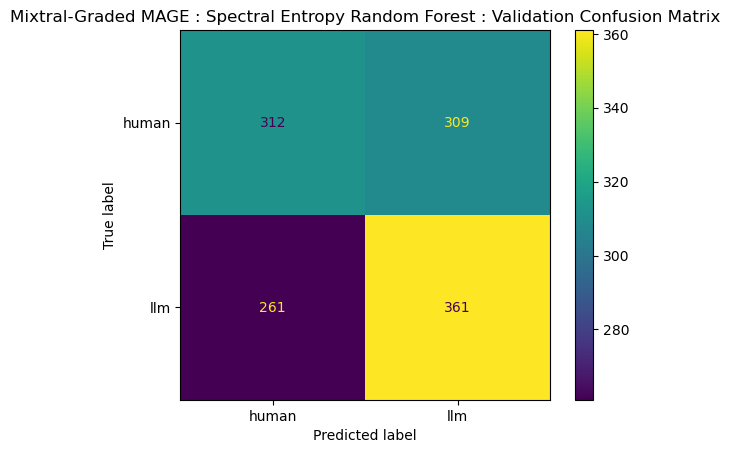

spectral_entropy_w128_std     0.259992
spectral_entropy_w64_std      0.254789
spectral_entropy_w128_mean    0.248878
spectral_entropy_w64_mean     0.236341
dtype: float64

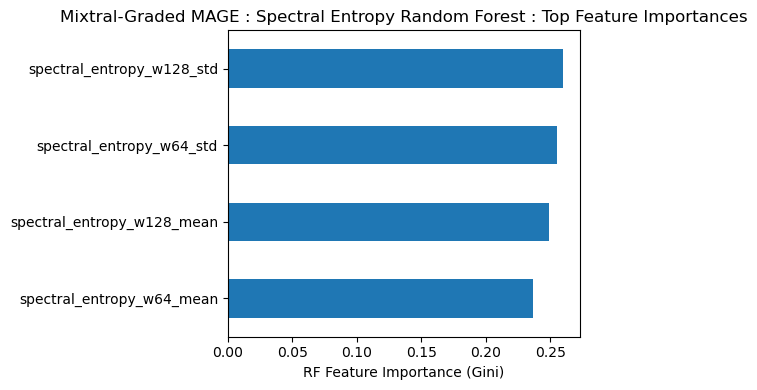

In [120]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=entropy_features,
    title='Mixtral-Graded MAGE : Spectral Entropy Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Mixtral-Graded MAGE : All Features Random Forest
accuracy (val):        0.648
precision_macro (val): 0.649
recall_macro (val):    0.648
f1_macro (val):        0.648
AUROC (val):           0.713


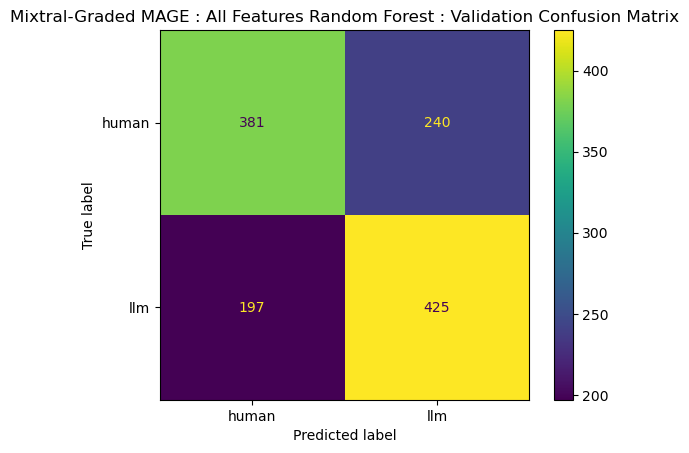

spectral_flatness_w128_mean           0.059519
spectral_flatness_w128_std            0.054108
spectral_flatness_w64_std             0.053549
spectral_slope_w64_mean               0.043588
spectral_entropy_w64_std              0.039698
spectral_flatness_w64_mean            0.038279
spectral_entropy_w128_std             0.038277
fft_energy_ratio_cut0.50_w64_mean     0.037740
spectral_entropy_w128_mean            0.036645
spectral_slope_w128_mean              0.035699
spectral_centroid_w128_std            0.035287
fft_energy_ratio_cut0.50_w128_mean    0.033039
spectral_centroid_w128_mean           0.032634
spectral_slope_w128_std               0.031995
spectral_slope_w64_std                0.031970
fft_energy_ratio_cut0.75_w64_mean     0.031924
fft_energy_ratio_cut0.90_w128_mean    0.031549
spectral_entropy_w64_mean             0.031516
spectral_centroid_w64_std             0.031253
spectral_centroid_w64_mean            0.031048
dtype: float64

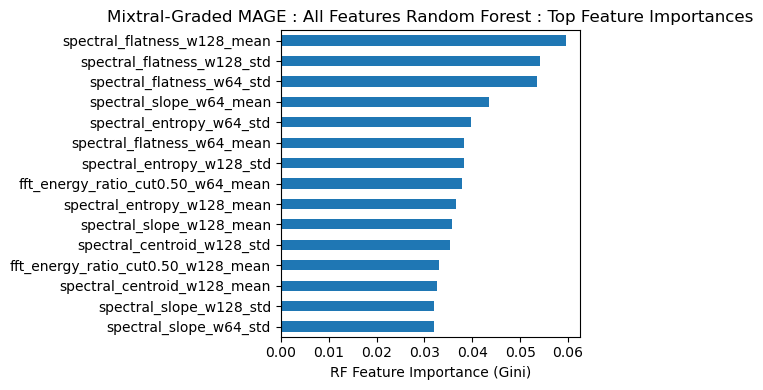

In [121]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Mixtral-Graded MAGE : All Features Random Forest'
)

## RESULTS (MAGE, Mixtral-Graded)
0.648 F1 score.  Not good.